In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from skimage.segmentation import mark_boundaries

import torch
from torchvision import transforms
from torch.utils.data import Dataset, RandomSampler, DataLoader
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms.functional import rgb_to_grayscale
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

from lime import lime_image

import os
import platform
from tqdm.notebook import tqdm
from collections import defaultdict

In [2]:
if platform.system() == 'Darwin':
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='mps')

# Load data

In [3]:
project_dir = os.path.abspath('')
data_dir = os.path.join('data', 'MedMNIST')
data_paths = os.path.join(project_dir, data_dir)
classes = os.listdir(data_paths)
classes

['Hand', 'BreastMRI', 'ChestCT', 'HeadCT', 'AbdomenCT', 'CXR']

In [4]:
data_annotations = defaultdict(list)
for med_class in tqdm(classes):
    images_paths = [os.path.join(data_paths, med_class, image)
                    for image in os.listdir(os.path.join(data_paths, med_class))]
    labels = [med_class] * len(images_paths)
    data_annotations['path'].extend(images_paths)
    data_annotations['label'].extend(labels)
df_annotations = pd.DataFrame.from_dict(data_annotations).sample(frac=1)

  0%|          | 0/6 [00:00<?, ?it/s]

In [5]:
df_annotations.head(5)

,path,label
33782,/Users/daniel/Study/Введение в нейросети/home...,HeadCT
53003,/Users/daniel/Study/Введение в нейросети/home...,CXR
8152,/Users/daniel/Study/Введение в нейросети/home...,Hand
30562,/Users/daniel/Study/Введение в нейросети/home...,HeadCT
48798,/Users/daniel/Study/Введение в нейросети/home...,AbdomenCT


# Data analysis

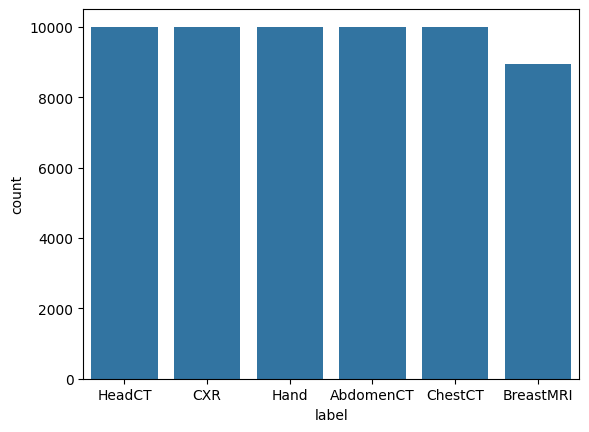

In [6]:
sns.countplot(data=df_annotations, x='label');

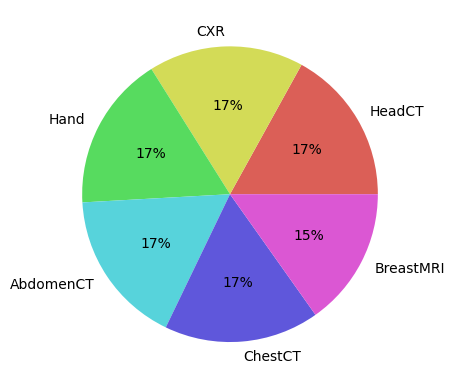

In [7]:
colors = sns.color_palette("hls", 6)
x = [df_annotations[df_annotations['label'] == med_class].shape[0] for med_class in df_annotations['label'].unique()]
plt.pie(x=x, colors=colors, labels=df_annotations['label'].unique(), autopct='%0.0f%%');

# Split data

In [8]:
df_train, df_test = train_test_split(df_annotations, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train, test_size=0.1)
df_train.head(5)

,path,label
41270,/Users/daniel/Study/Введение в нейросети/home...,AbdomenCT
16225,/Users/daniel/Study/Введение в нейросети/home...,BreastMRI
21376,/Users/daniel/Study/Введение в нейросети/home...,ChestCT
54125,/Users/daniel/Study/Введение в нейросети/home...,CXR
5080,/Users/daniel/Study/Введение в нейросети/home...,Hand


In [9]:
df_train.shape, df_val.shape, df_test.shape

((42446, 2), (4717, 2), (11791, 2))

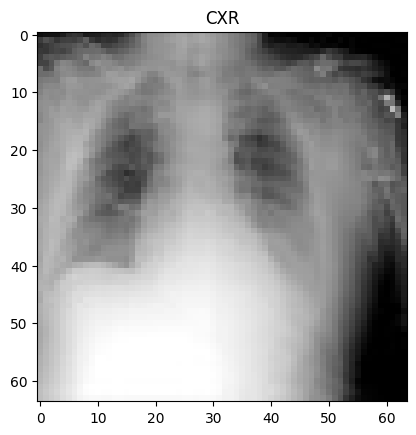

In [10]:
random_idx = np.random.randint(0, df_train.shape[0])
rand_path, rand_label = df_train.iloc[random_idx]
rand_img = Image.open(rand_path).convert('L')
plt.imshow(rand_img, cmap='gray')
plt.title(rand_label);

# Transform images

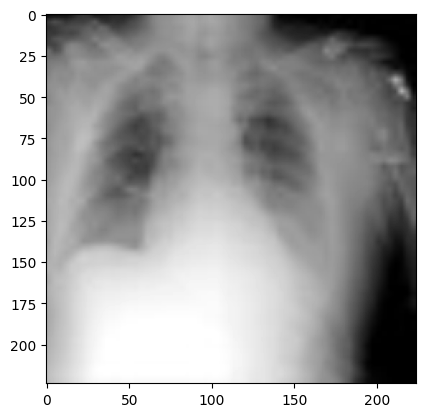

In [11]:
transform_img = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


rand_img_tensor = transform_img(rand_img)
plt.imshow(rand_img_tensor.permute(1, 2, 0), cmap='gray');

# Create Torch Dataset

In [12]:
class MedMNISTDataset(Dataset):
    def __init__(self, df_annotations, classes, transform_img):
        self.df_annotations = df_annotations
        self.classes = classes
        self.transform_img = transform_img

    def __len__(self):
        return self.df_annotations.shape[0]

    def __getitem__(self, idx):
        img_path, label = self.df_annotations.iloc[idx]
        label = self.classes[label]
        img = Image.open(img_path).convert('L')
        img = self.transform_img(img)
        label = torch.tensor(label, dtype=torch.long)
        return img, label

In [13]:
def get_dataloader(df, classes, transform_img, batch_size):
    dataset = MedMNISTDataset(df, classes, transform_img)
    sampler = RandomSampler(dataset)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, sampler=sampler)
    return dataloader


batch_size = 64
classes_dict = dict(zip(classes, range(len(classes))))
train_loader = get_dataloader(df_train, classes_dict, transform_img, batch_size)
val_loader = get_dataloader(df_val, classes_dict, transform_img, batch_size)
test_loader = get_dataloader(df_test, classes_dict, transform_img, batch_size)

In [14]:
next(iter(train_loader))

[tensor([[[[0.9098, 0.9098, 0.7608,  ..., 0.0706, 0.0706, 0.0706],
           [0.9098, 0.9098, 0.7608,  ..., 0.0706, 0.0706, 0.0706],
           [0.9098, 0.9098, 0.7608,  ..., 0.0706, 0.0706, 0.0706],
           ...,
           [0.7882, 0.7882, 0.6745,  ..., 0.1216, 0.1216, 0.1216],
           [0.8235, 0.8235, 0.7098,  ..., 0.1373, 0.1373, 0.1373],
           [0.8235, 0.8235, 0.7098,  ..., 0.1373, 0.1373, 0.1373]]],
 
 
         [[[0.0706, 0.0706, 0.0706,  ..., 0.1059, 0.1137, 0.1137],
           [0.0706, 0.0706, 0.0706,  ..., 0.1059, 0.1137, 0.1137],
           [0.0706, 0.0706, 0.0706,  ..., 0.1059, 0.1137, 0.1137],
           ...,
           [0.2275, 0.2275, 0.1882,  ..., 0.1059, 0.1059, 0.1059],
           [0.2275, 0.2275, 0.1882,  ..., 0.1059, 0.1059, 0.1059],
           [0.2275, 0.2275, 0.1882,  ..., 0.1059, 0.1059, 0.1059]]],
 
 
         [[[0.0549, 0.0549, 0.0431,  ..., 0.3882, 0.4078, 0.4078],
           [0.0549, 0.0549, 0.0431,  ..., 0.3882, 0.4078, 0.4078],
           [0.0549

# ResNet

In [15]:
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
for param in model.parameters():
    param.requires_grad = False
model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.fc = nn.Linear(512, 6)

# Until train

In [17]:
def screens_predict(imgs):
    model.eval()
    batch = torch.stack(tuple(torch.tensor(i) for i in imgs), dim=0)
    model.to(device)
    batch = rgb_to_grayscale(batch.to(device).permute(0, 3, 1, 2))
    with torch.no_grad():
        outputs = model(batch)
        probs = nn.Softmax(dim=1)(outputs)
    return probs.detach().cpu().numpy()

In [18]:
test_batch = next(iter(train_loader))
test_tensor = test_batch[0][0]
test_label = test_batch[1][0]
prob_test = nn.Softmax(dim=1)(model(test_tensor.unsqueeze(0))).squeeze()
print(classes[prob_test.argmax().item()])

CXR


In [19]:
test_tensor.shape

torch.Size([1, 224, 224])

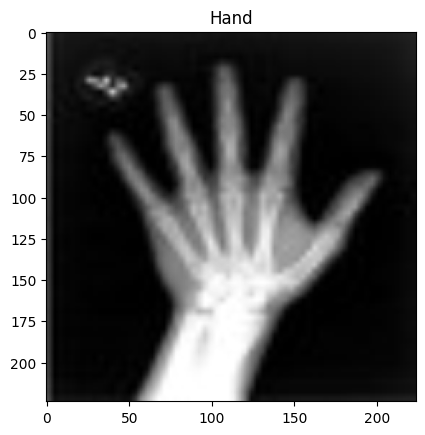

In [20]:
plt.imshow(test_tensor.permute(1, 2, 0), cmap='gray')
plt.title(classes[test_label]);

In [21]:
screens_predict(test_tensor.unsqueeze(0).repeat(1, 3, 1, 1).permute(0, 2, 3, 1))

/var/folders/sh/5fkv5ddj06zczqfxsfj04y9c0000gn/T/ipykernel_22280/2400087501.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch = torch.stack(tuple(torch.tensor(i) for i in imgs), dim=0)


array([[0.37150022, 0.09876022, 0.10505303, 0.16125014, 0.11260001,
        0.1508364 ]], dtype=float32)

In [22]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(test_tensor.repeat(3, 1, 1).permute(1, 2, 0).numpy(), 
                                         screens_predict,
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [23]:
explanation.top_labels

[0, 3, 5, 4, 2]

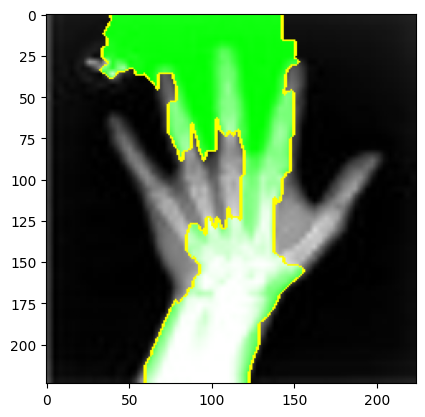

In [24]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
img_boundry = mark_boundaries(temp, mask)
plt.imshow(img_boundry);

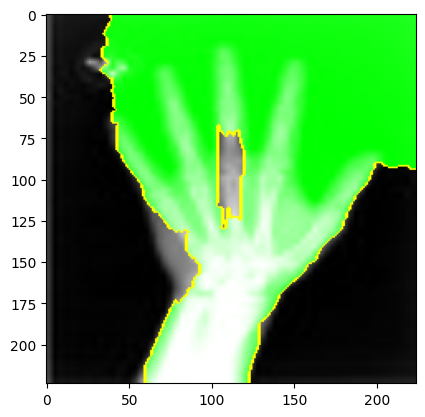

In [25]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
img_boundry = mark_boundaries(temp, mask)
plt.imshow(img_boundry);

# Train functions

In [26]:
def train_on_batch(model, x_batch, y_batch, criterion, optimizer):
    model.train()
    model.to(device)
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    outputs = model(x_batch).squeeze()
    loss = criterion(outputs, y_batch)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    probs = nn.Softmax(dim=-1)(outputs)
    return probs.argmax(dim=-1), loss.cpu().item()

In [27]:
def train_epoch(model, train_loader, criterion, optimizer):
    epoch_loss = 0
    y_preds = np.array([])
    y_true = np.array([])
    total = 0
    for x_batch, y_batch in tqdm(train_loader):
        preds, batch_loss = train_on_batch(model, x_batch, y_batch, criterion, optimizer)
        preds = preds.detach().cpu()
        epoch_loss += batch_loss
        y_preds = np.concatenate((y_preds, preds.detach().cpu().numpy()))
        y_true = np.concatenate((y_true, y_batch.detach().cpu().numpy()))
        total += len(x_batch)
    return epoch_loss/total, accuracy_score(y_true, y_preds), precision_score(y_true, y_preds, average='macro'), \
        recall_score(y_true, y_preds, average='macro')

In [28]:
def evaluate_on_batch(model, x_batch, y_batch, criterion):
    model.eval()
    model.to(device)
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
    with torch.no_grad():
        outputs = model(x_batch).squeeze()
        loss = criterion(outputs, y_batch)
        probs = nn.Softmax(dim=-1)(outputs)
    return probs.argmax(dim=-1), loss.cpu().item()

In [29]:
def evaluate_epoch(model, val_loader, criterion):
    epoch_loss = 0
    y_preds = np.array([])
    y_true = np.array([])
    total = 0
    for x_batch, y_batch in tqdm(val_loader):
        preds, batch_loss = evaluate_on_batch(model, x_batch, y_batch, criterion)
        preds = preds.detach().cpu()
        epoch_loss += batch_loss
        y_preds = np.concatenate((y_preds, preds.detach().cpu().numpy()))
        y_true = np.concatenate((y_true, y_batch.detach().cpu().numpy()))
        total += len(x_batch)
    return epoch_loss/total, accuracy_score(y_true, y_preds), precision_score(y_true, y_preds, average='macro'), \
        recall_score(y_true, y_preds, average='macro')

In [30]:
def writer_log(writer, results, epoch, is_train=True):
    results_dict = {
        'loss': results[0],
        'accuracy': results[1],
        'precision': results[2],
        'recall': results[3]
    }
    text = 'train' if is_train else 'val'
    for key, val in results_dict.items():
        writer.add_scalar(f'{key}/{text}', val, epoch)


def train(model, num_epochs, train_loader, val_loader, criterion,
          optimizer, lr_scheduler=None, writer=None):
    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch: {epoch+1}/{num_epochs}')
        print('Train')
        results = train_epoch(model, train_loader, criterion, optimizer)
        writer_log(writer, results, epoch)
        print(f'Loss: {results[0]}')
        if lr_scheduler is not None:
            lr_scheduler.step()
        print('Val')
        results = evaluate_epoch(model, val_loader, criterion)
        writer_log(writer, results, epoch, False)
        print(f'Loss: {results[0]}')

In [31]:
lr = 1e-3
num_epochs = 3
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer,
                                                gamma=0.9, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


In [32]:
%load_ext tensorboard
%tensorboard --logdir experiment/

In [33]:
writer = SummaryWriter(log_dir='experiment')
train(model, num_epochs, train_loader, val_loader, criterion,
      optimizer, lr_scheduler, writer)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1/3
Train


  0%|          | 0/664 [00:00<?, ?it/s]

Loss: 0.0008793354320659719
Adjusting learning rate of group 0 to 9.0000e-04.
Val


  0%|          | 0/74 [00:00<?, ?it/s]

Loss: 0.0020182211376933543
Epoch: 2/3
Train


  0%|          | 0/664 [00:00<?, ?it/s]

Loss: 7.192519633998484e-05
Adjusting learning rate of group 0 to 8.1000e-04.
Val


  0%|          | 0/74 [00:00<?, ?it/s]

Loss: 0.0001645486053369208
Epoch: 3/3
Train


  0%|          | 0/664 [00:00<?, ?it/s]

Loss: 4.961366846919596e-05
Adjusting learning rate of group 0 to 7.2900e-04.
Val


  0%|          | 0/74 [00:00<?, ?it/s]

Loss: 1.093251371493552e-05


# Test model

In [35]:
def test_model(model, test_loader, device):
    model.eval()
    model.to(device)
    y_preds = np.array([])
    y_true = np.array([])
    for x_batch, y_batch in tqdm(test_loader):
        with torch.no_grad():
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch).squeeze()
            probs = nn.Softmax(dim=-1)(outputs)
            preds = probs.argmax(dim=-1)
            y_preds = np.concatenate((y_preds, preds.detach().cpu().numpy()))
            y_true = np.concatenate((y_true, y_batch.detach().cpu().numpy()))
    return accuracy_score(y_true, y_preds), precision_score(y_true, y_preds, average='macro'), \
        recall_score(y_true, y_preds, average='macro')

In [37]:
results = test_model(model, test_loader, device)

  0%|          | 0/185 [00:00<?, ?it/s]

accuracy: 1


In [48]:
print(f'accuracy: {results[0]*100:.4f}%')
print(f'precision: {results[1]*100:.4f}%')
print(f'recall: {results[2]*100:.4f}%')

accuracy: 99.9830%
precision: 99.9823%
recall: 99.9835%


# Interpretate results

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

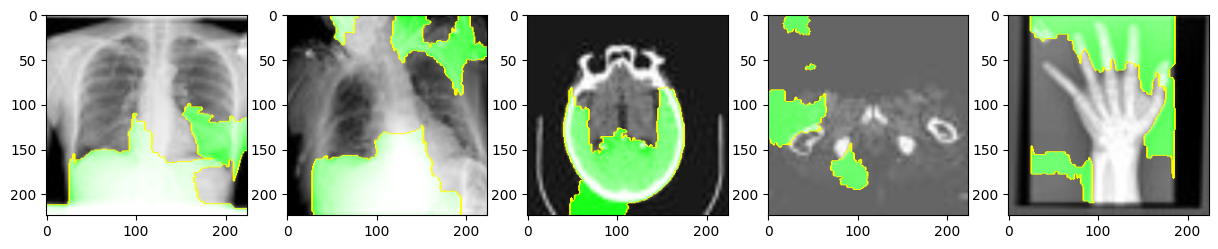

In [56]:
explainer = lime_image.LimeImageExplainer()
x_batch, _ = next(iter(test_loader))
fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 5)
ax = np.empty([5], dtype=object)
for i in range(5):
      ax[i] = fig.add_subplot(gs[i])
for i in range(5):
    img_tensor = x_batch[i]
    explanation = explainer.explain_instance(img_tensor.repeat(3, 1, 1).permute(1, 2, 0).numpy(), 
                                             screens_predict,
                                             top_labels=5, 
                                             hide_color=0, 
                                             num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
    img_boundry = mark_boundaries(temp, mask)
    ax[i].imshow(img_boundry)
plt.show();